In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pyarrow.parquet as pq

# Open Parquet file
parquet_file = pq.ParquetFile("C:/Datasets/Parquets/ecom.parquet")

dfs = []

# Read in row batches
for batch in parquet_file.iter_batches(batch_size=1_000_000):
    dfs.append(batch.to_pandas())
    # process each batch separately

ecommerce = pd.concat(dfs, ignore_index=True)

In [3]:
ecommerce.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,category,type
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,appliances,sewing_machine
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,unknown,unknown
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,appliances,kitchen.washer
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,electronics,smartphone


In [4]:
ecommerce.shape

(67501969, 10)

In [5]:
ecommerce.isna().sum()

event_time      0
event_type      0
product_id      0
category_id     0
brand           0
price           0
user_id         0
user_session    0
category        0
type            0
dtype: int64

In [6]:
ecommerce.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67501969 entries, 0 to 67501968
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   event_time    object 
 1   event_type    object 
 2   product_id    int64  
 3   category_id   int64  
 4   brand         object 
 5   price         float64
 6   user_id       int64  
 7   user_session  object 
 8   category      object 
 9   type          object 
dtypes: float64(1), int64(3), object(6)
memory usage: 5.0+ GB


In [7]:
ecommerce.describe()

,product_id,category_id,price,user_id
count,6.750197e+07,6.750197e+07,6.750197e+07,6.750197e+07
mean,1.251407e+07,2.057898e+18,2.924593e+02,5.386397e+08
std,1.725741e+07,2.012549e+16,3.556745e+02,2.288516e+07
min,1.000365e+06,2.053014e+18,0.000000e+00,1.030022e+07
25%,1.305977e+06,2.053014e+18,6.924000e+01,5.164762e+08
50%,5.100568e+06,2.053014e+18,1.657700e+02,5.350573e+08
75%,1.730075e+07,2.053014e+18,3.603400e+02,5.610794e+08
max,1.000286e+08,2.187708e+18,2.574070e+03,5.799699e+08


# EDA + Feature Engineering

In [8]:
price_bin = [0,500,1500,float('inf')]
price_labels = ['budget','medium','premium']

ecommerce['price_range'] = pd.cut(ecommerce['price'], bins=price_bin, labels=price_labels)

In [9]:
ecommerce.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,category,type,price_range
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,electronics,smartphone,budget
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,appliances,sewing_machine,budget
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,unknown,unknown,budget
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,appliances,kitchen.washer,medium
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,electronics,smartphone,budget


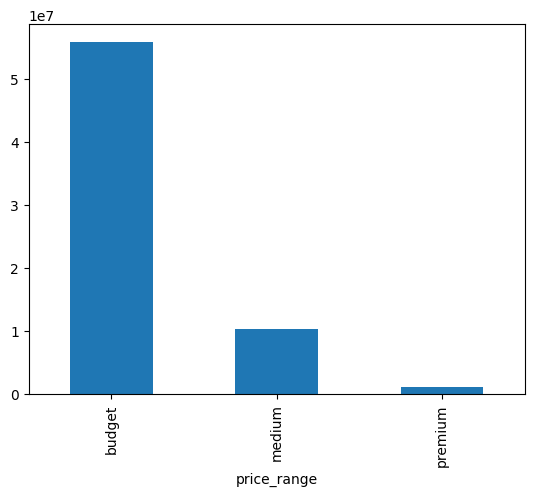

In [12]:
ecommerce['price_range'].value_counts().plot(kind='bar')
plt.show()

In [15]:
pd.crosstab(ecommerce['price_range'], ecommerce['event_type'], normalize='index')

event_type,cart,purchase,view
price_range,,,
budget,0.045041,0.013510,0.941449
medium,0.045477,0.014539,0.939984
premium,0.034726,0.010826,0.954448


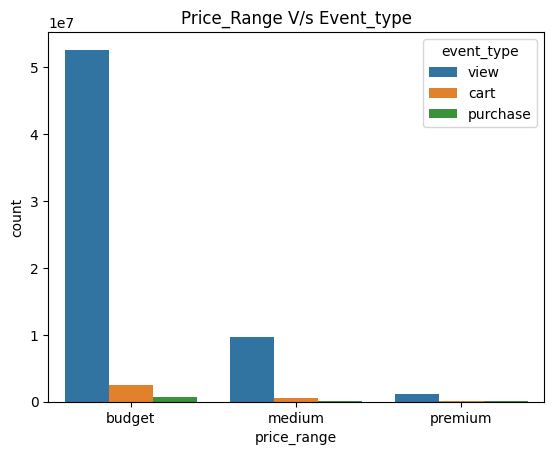

In [16]:
sns.countplot(data=ecommerce, x='price_range', hue='event_type')
plt.title("Price_Range V/s Event_type")
plt.show()

In [17]:
conv_data = ecommerce[ecommerce['event_type'].isin(['cart', 'purchase'])]

conversion_rates = (
    conv_data
    .groupby(['price_range', 'event_type'])
    .size()
    .unstack()
    .fillna(0)
)

conversion_rates['total'] = conversion_rates.sum(axis=1)
conversion_rates['purchase_rate'] = conversion_rates['purchase'] / conversion_rates['total']
conversion_rates.head()


C:\Users\divya\AppData\Local\Temp\ipykernel_19432\14386176.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['price_range', 'event_type'])


event_type,cart,purchase,total,purchase_rate
price_range,,,,
budget,2516389,754808,3271197,0.230744
medium,468267,149706,617973,0.242253
premium,39856,12425,52281,0.237658


<Axes: xlabel='price_range', ylabel='hour'>

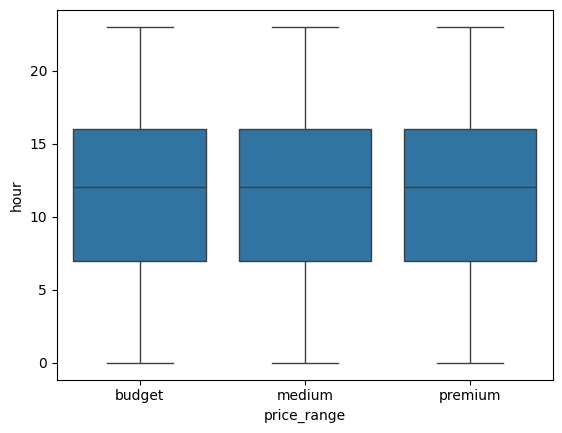

In [18]:
ecommerce['event_time'] = pd.to_datetime(ecommerce['event_time'])

ecommerce['hour'] = ecommerce['event_time'].dt.hour
sns.boxplot(data=ecommerce, x='price_range', y='hour')


### Interaction Intensity

In [19]:
event_map = {'view': 0, 'cart': 1, 'purchase': 2}
ecommerce['event_score'] = ecommerce['event_type'].map(event_map)

In [20]:
ecommerce.groupby('price_range')['event_score'].mean()

C:\Users\divya\AppData\Local\Temp\ipykernel_19432\1988156679.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ecommerce.groupby('price_range')['event_score'].mean()


price_range
budget     0.072061
medium     0.074556
premium    0.056377
Name: event_score, dtype: float64